# Papers:
- [Deep Fake Detector](http://cs230.stanford.edu/projects_winter_2019/reports/15812450.pdf)

In [1]:
import os
import cv2
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

In [2]:
CLASSES_IDS = {
    'REAL': 0,
    'FAKE': 1
}

CLASSES_NAMES = {
    0: 'real',
    1: 'fake'
}

class DeepFakeDataset(Dataset):
    """Fake vs Real."""

    def __init__(self, root_dir, split='train', transform=None):
        assert split in ['train', 'test']
        
        self.__root_dir = root_dir
        self.__split = split
        self.__transform = transform

        self.__split_dir = os.path.join(root_dir, split)
        self.__classes = os.listdir(self.__split_dir)

        self.__image_labels = []
        self.__images = []

        for cls in self.__classes:
            for image in os.listdir(os.path.join(self.__split_dir, cls)):
                self.__image_labels.append(cls)
                self.__images.append(image)

        assert len(self.__images) == len(self.__image_labels)

    @property
    def split(self):
        return self.__split

    @property
    def num_classes(self):
        return len(self.__classes)

    def __len__(self):
        return len(self.__images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_label = self.__image_labels[idx]
        image_name = os.path.join(self.__root_dir,
                                  self.__split,
                                  image_label,
                                  self.__images[idx])
        
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.__transform:
            image = self.__transform(image)

        probs = np.zeros((self.num_classes, ))
        probs[CLASSES_IDS[image_label]] = 1

        return image, probs

In [3]:
def plt_dataset(dataset, indices, row_size=8, title=None):
    fig, ax = plt.subplots(nrows=math.ceil(len(indices) / row_size), ncols=row_size, figsize=(12, 8))

    if title:
        fig.suptitle(f'Fake vs. Real Dataset: {title}', fontsize=28)
    else:
        fig.suptitle('Fake vs. Real Dataset', fontsize=28)
    
    for i, index in enumerate(indices):
        image, probs = dataset[index]
        label_id = np.argmax(probs)

        if type(image) is torch.tensor:
            image = image.detach().cpu().numpy()
            image = image.transpose((1, 2, 0))

        grid_i = i // row_size
        grid_j = i % row_size

        ax[grid_i, grid_j].axis("off")
        ax[grid_i, grid_j].set_title(f"{CLASSES_NAMES[label_id]} ({label_id})")
        ax[grid_i, grid_j].imshow(image)

Split train
It contains 18618 images


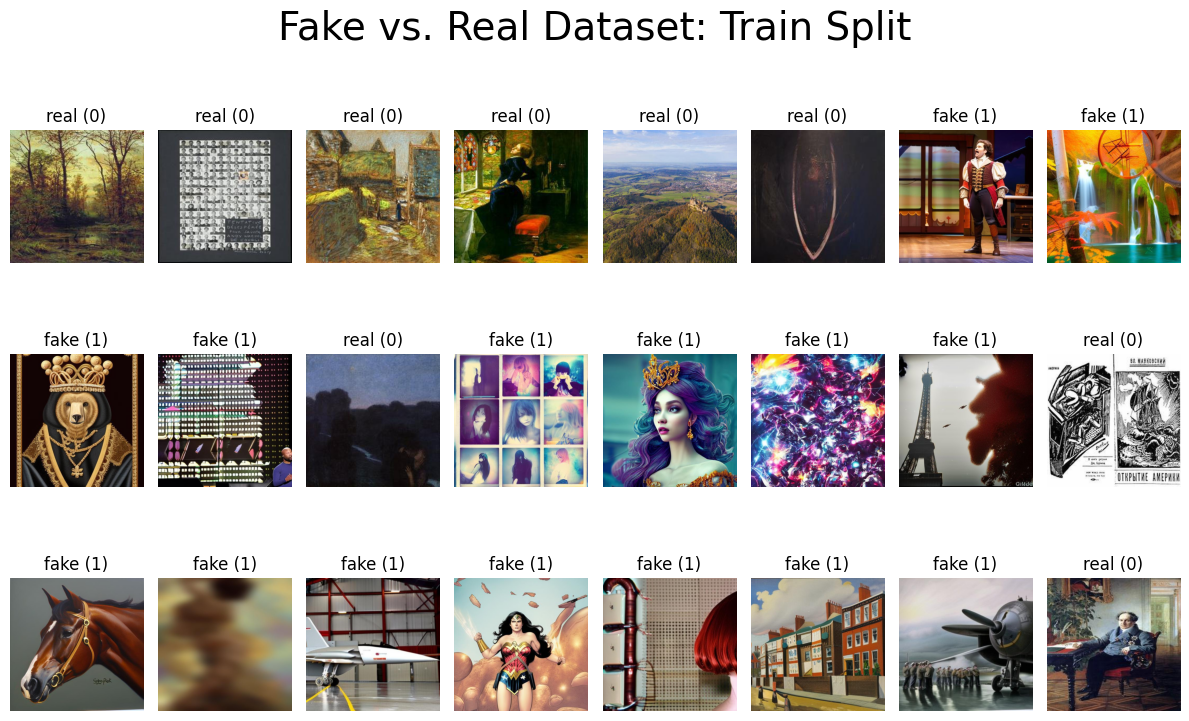

In [4]:
dataset = DeepFakeDataset('./temp/dataset')
indices = np.random.randint(0, len(dataset), 24)

print(f'Split {dataset.split}')
print(f'It contains {len(dataset)} images')

plt_dataset(dataset, indices, title='Train Split')
plt.tight_layout()
plt.show()

Split test
It contains 2181 images


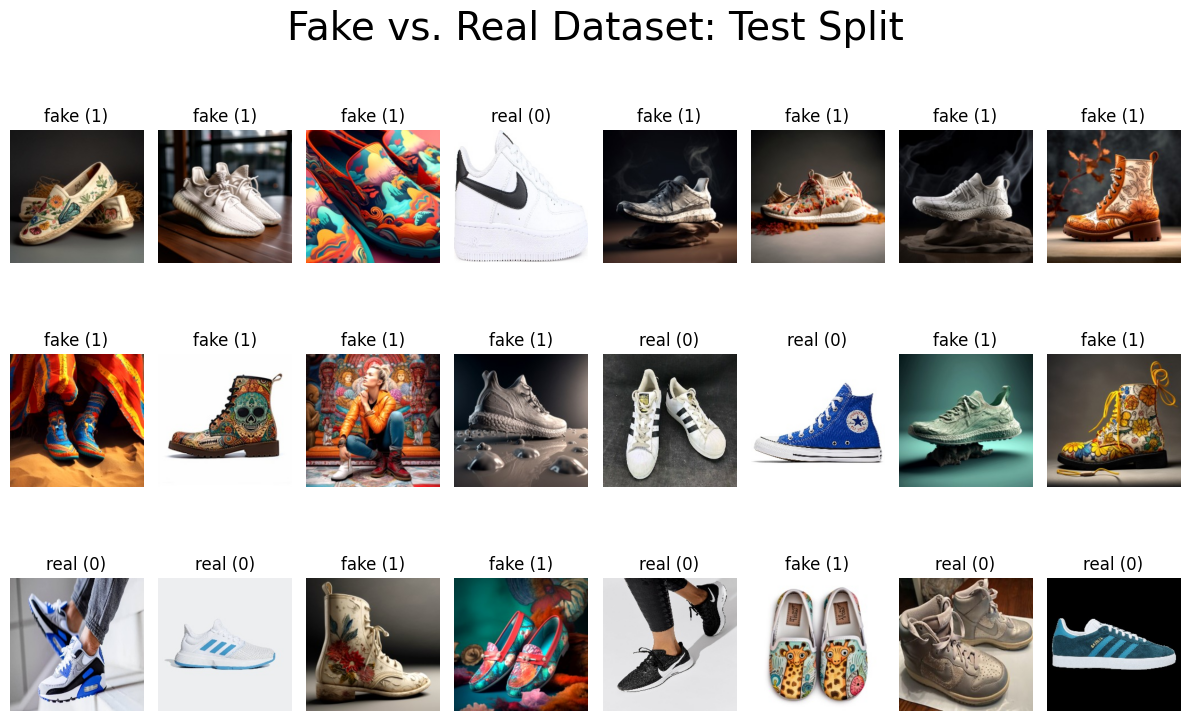

In [5]:
dataset = DeepFakeDataset('./temp/dataset', split='test')
indices = np.random.randint(0, len(dataset), 24)

print(f'Split {dataset.split}')
print(f'It contains {len(dataset)} images')

plt_dataset(dataset, indices, title='Test Split')
plt.tight_layout()
plt.show()

# Training+Validation utils

In [6]:
def get_accuracy(trues, 
                 predictions):
    trues, predictions = trues.detach().cpu(), predictions.detach().cpu()
    return (np.argmax(trues, axis=1) == np.argmax(predictions, axis=1)).mean(dtype=torch.float32)

def train(model, 
          train_dataloader, 
          criterion, 
          optimizer, 
          scheduler, 
          grad_clip, 
          device='cpu'):
    model.to(device)
    model.train()

    losses = []
    accuracies = []
    
    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = inputs.float(), labels.float()

        predictions = model(inputs)  
        loss = criterion(predictions, labels)
        loss.backward()

        if grad_clip: 
            torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        losses.append(loss.item())
        accuracies.append(get_accuracy(labels, predictions))

    mean_accuracy = np.mean(accuracies)
    mean_loss = np.mean(losses)
    return model, mean_accuracy, mean_loss

def validation(model,
               val_dataloader,
               criterion,
               device='cpu'):    
    model.to(device)
    model.eval()
    
    losses = []
    accuracies = []

    for inputs, labels in tqdm(val_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = inputs.float(), labels.float()
        
        with torch.no_grad():   
            predictions = model(inputs)

            loss = criterion(predictions, labels)

            losses.append(loss.item())
            accuracies.append(get_accuracy(labels, predictions))

    mean_accuracy = np.mean(accuracies)
    mean_loss = np.mean(losses)
    return mean_accuracy, mean_loss

In [7]:
def create_net(num_classes,
               model_type,
               pretrained):
    if pretrained and model_type == 'resnet18':
        weights = 'ResNet18_Weights.IMAGENET1K_V1'
    elif pretrained and model_type == 'resnet34':
        weights = 'ResNet34_Weights.IMAGENET1K_V1'
    elif pretrained and model_type == 'resnet50':
        weights = 'ResNet50_Weights.IMAGENET1K_V2'
    else:
        weights = None
    
    if model_type == 'resnet18':
        model = torchvision.models.resnet18(weights=weights)
    elif model_type == 'resnet34':
        model = torchvision.models.resnet34(weights=weights)
    elif model_type == 'resnet50':
        model = torchvision.models.resnet50(weights=weights)
    else:
        raise Exception(f'Unknown model type: {model_type}')

    num_inputs = model.fc.in_features
    model.fc = torch.nn.Linear(num_inputs, num_classes)
    return model

In [8]:
train_dataset = DeepFakeDataset('./temp/dataset', split='train', transform=v2.Compose([
    v2.Resize(240, 240),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
]))
test_dataset = DeepFakeDataset('./temp/dataset', split='test', transform=v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
]))

In [9]:
def save_state(epoch,
               config,
               model,
               optimizer,
               file_path="./best_state.pth"):
    state = {
    'epoch': epoch,
    'config': config,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    }
    
    torch.save(state, file_path)

In [10]:
def run_experiment(config):
    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS']) 
    test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])
    
    model = create_net(num_classes=config['NUM_CLASSES'], model_type=config['MODEL'], pretrained=config['MODEL_PRETRAINED'])
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['LR'], weight_decay=config['WEIGHT_DECAY'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                    config['LR'], 
                                                    epochs=config['NUM_EPOCHS'], 
                                                    steps_per_epoch=len(train_loader))
    
    train_accuracy = []
    train_loss = []
    
    val_accuracy = []
    val_loss = []
    
    best_accuracy = 0 
    
    for epoch in range(config['NUM_EPOCHS']):
        print(f"Epoch #{epoch} started.")
        
        model, t_acc, t_loss = train(model, train_loader, criterion, optimizer, scheduler, grad_clip=config['GRAD_CLIP'], device=config['DEVICE'])
        train_accuracy.append(t_acc)
        train_loss.append(t_loss)
    
        print(f"Train loss: {t_loss}, accuracy: {t_acc}")
    
        v_acc, v_loss = validation(model, test_loader, criterion, device=config['DEVICE'])
        val_accuracy.append(v_acc) 
        val_loss.append(v_loss)
    
        print(f"Validation loss: {v_loss}, accuracy: {v_acc}")
    
        if v_acc > best_accuracy:
            print(f"Saving best accuracy so far, {v_acc}")
            best_accuracy = v_acc
            save_state(epoch, config, model, optimizer, file_path=f"./temp/best_state_{v_acc:.2f}.pth")

    return train_loss, train_accuracy, val_loss, val_accuracy, best_accuracy

In [11]:
def plot_experiment(train_loss, train_accuracy, val_loss, val_accuracy):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    ax[0, 0].set_title("Train loss")
    ax[0, 0].plot(train_loss)
    
    ax[0, 1].set_title("Train accuracy")
    ax[0, 1].plot(train_accuracy)
    
    ax[1, 0].set_title("Validation loss")
    ax[1, 0].plot(val_loss)
    
    ax[1, 1].set_title("Validation accuracy")
    ax[1, 1].plot(val_accuracy)
    
    plt.tight_layout()
    plt.show()

# ResNet18 
- No Weights
- 25 epochs

In [12]:
config = dict()
config['MODEL'] = 'resnet18'
config['MODEL_PRETRAINED'] = False
config['NUM_CLASSES'] = 2
config['NUM_WORKERS'] = 0
config['BATCH_SIZE'] = 32
# x.com/karpathy/status/801621764144971776
config['LR'] = 3e-4
config['GRAD_CLIP'] = 0.1
config['DEVICE'] = 'cpu' if not torch.cuda.is_available() else 'cuda'
config['WEIGHT_DECAY'] = 1e-4
config['NUM_EPOCHS'] = 25

In [13]:
train_loss, train_accuracy, val_loss, val_accuracy, best_accuracy = run_experiment(config)

Epoch #0 started.


100%|█████████████████████████████████████████████████████████████████████████████████| 582/582 [53:44<00:00,  5.54s/it]


Train loss: 0.37658902774868963, accuracy: 0.8283976316452026


100%|███████████████████████████████████████████████████████████████████████████████████| 69/69 [01:08<00:00,  1.01it/s]


Validation loss: 1.306021852661734, accuracy: 0.6566123366355896
Saving best accuracy so far, 0.6566123366355896
Epoch #1 started.


100%|█████████████████████████████████████████████████████████████████████████████████| 582/582 [37:13<00:00,  3.84s/it]


Train loss: 0.2643596730050967, accuracy: 0.8881467580795288


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [01:03<00:00,  1.09it/s]


Validation loss: 0.9540222995523093, accuracy: 0.5730072259902954
Epoch #2 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [35:23<00:00,  3.65s/it]


Train loss: 0.23633780586453237, accuracy: 0.8984643220901489


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:43<00:00,  1.60it/s]


Validation loss: 1.9923958583478478, accuracy: 0.6707427501678467
Saving best accuracy so far, 0.6707427501678467
Epoch #3 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [35:35<00:00,  3.67s/it]


Train loss: 0.20741046859508322, accuracy: 0.9114583134651184


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.64it/s]


Validation loss: 1.024712181177692, accuracy: 0.5449275374412537
Epoch #4 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:51<00:00,  3.59s/it]


Train loss: 0.18770491904051034, accuracy: 0.9212636947631836


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:41<00:00,  1.66it/s]


Validation loss: 1.3027458352887111, accuracy: 0.5907608866691589
Epoch #5 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:37<00:00,  3.57s/it]


Train loss: 0.1752063197266195, accuracy: 0.9219741225242615


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.63it/s]


Validation loss: 1.3098492015531098, accuracy: 0.4913043677806854
Epoch #6 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:52<00:00,  3.60s/it]


Train loss: 0.1550237248368446, accuracy: 0.9327501654624939


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [01:03<00:00,  1.09it/s]


Validation loss: 1.4402268528938293, accuracy: 0.5339673757553101
Epoch #7 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [35:03<00:00,  3.61s/it]


Train loss: 0.14723651158812223, accuracy: 0.9360916018486023


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.60it/s]


Validation loss: 1.4854269140008567, accuracy: 0.4591485559940338
Epoch #8 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:46<00:00,  3.59s/it]


Train loss: 0.13463112555245815, accuracy: 0.9441993832588196


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.63it/s]


Validation loss: 1.633597681487816, accuracy: 0.6086956262588501
Epoch #9 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:50<00:00,  3.59s/it]


Train loss: 0.12205943194317193, accuracy: 0.9497299194335938


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:41<00:00,  1.67it/s]


Validation loss: 1.5513990400494009, accuracy: 0.5964673757553101
Epoch #10 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:24<00:00,  3.55s/it]


Train loss: 0.10738336874485732, accuracy: 0.9567267298698425


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:41<00:00,  1.66it/s]


Validation loss: 1.6581554037073385, accuracy: 0.44465580582618713
Epoch #11 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:29<00:00,  3.56s/it]


Train loss: 0.09501867133106306, accuracy: 0.9603613615036011


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.62it/s]


Validation loss: 1.3640992028125818, accuracy: 0.6204710006713867
Epoch #12 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:37<00:00,  3.57s/it]


Train loss: 0.07846498835385422, accuracy: 0.9692745804786682


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.61it/s]


Validation loss: 2.205283288506494, accuracy: 0.446739137172699
Epoch #13 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:59<00:00,  3.61s/it]


Train loss: 0.06014999329161277, accuracy: 0.9769651889801025


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [01:00<00:00,  1.15it/s]


Validation loss: 2.058978370998217, accuracy: 0.5295289754867554
Epoch #14 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [36:05<00:00,  3.72s/it]


Train loss: 0.0459588908724794, accuracy: 0.9824833273887634


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:41<00:00,  1.66it/s]


Validation loss: 2.6380705306495447, accuracy: 0.5249094367027283
Epoch #15 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [44:45<00:00,  4.61s/it]


Train loss: 0.029965299780031405, accuracy: 0.98931485414505


100%|███████████████████████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.40it/s]


Validation loss: 2.467954605385877, accuracy: 0.6034420132637024
Epoch #16 started.


100%|█████████████████████████████████████████████████████████████████████████████████| 582/582 [50:55<00:00,  5.25s/it]


Train loss: 0.0218198732395696, accuracy: 0.9920532703399658


100%|███████████████████████████████████████████████████████████████████████████████████| 69/69 [00:53<00:00,  1.30it/s]


Validation loss: 2.9555594908154528, accuracy: 0.573369562625885
Epoch #17 started.


100%|███████████████████████████████████████████████████████████████████████████████| 582/582 [1:28:41<00:00,  9.14s/it]


Train loss: 0.016723946350865878, accuracy: 0.994093656539917


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.60it/s]


Validation loss: 2.602476554504339, accuracy: 0.5570651888847351
Epoch #18 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [35:20<00:00,  3.64s/it]


Train loss: 0.008199099927963091, accuracy: 0.9976374506950378


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.62it/s]


Validation loss: 2.8655546635821247, accuracy: 0.5925724506378174
Epoch #19 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [35:42<00:00,  3.68s/it]


Train loss: 0.004498615136437421, accuracy: 0.9988723993301392


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:54<00:00,  1.27it/s]


Validation loss: 3.186191341151362, accuracy: 0.573097825050354
Epoch #20 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [35:00<00:00,  3.61s/it]


Train loss: 0.0020020066783977245, accuracy: 0.9997852444648743


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:41<00:00,  1.65it/s]


Validation loss: 3.17807792580646, accuracy: 0.5866848230361938
Epoch #21 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [46:40<00:00,  4.81s/it]


Train loss: 0.001739340928717953, accuracy: 0.9997315406799316


100%|███████████████████████████████████████████████████████████████████████████████████| 69/69 [01:01<00:00,  1.12it/s]


Validation loss: 3.159367749656456, accuracy: 0.5776268243789673
Epoch #22 started.


100%|███████████████████████████████████████████████████████████████████████████████| 582/582 [1:53:44<00:00, 11.73s/it]


Train loss: 0.0015505241598783403, accuracy: 0.9997315406799316


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:59<00:00,  1.16it/s]


Validation loss: 3.0937201942222705, accuracy: 0.5875905752182007
Epoch #23 started.


100%|█████████████████████████████████████████████████████████████████████| 582/582 [1:02:48<00:00,  6.47s/it]


Train loss: 0.0005911066836674342, accuracy: 1.0


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:59<00:00,  1.15it/s]


Validation loss: 3.2162052272022637, accuracy: 0.5726449489593506
Epoch #24 started.


100%|█████████████████████████████████████████████████████████████████████| 582/582 [1:15:30<00:00,  7.79s/it]


Train loss: 0.0006882102570764884, accuracy: 0.9998925924301147


100%|███████████████████████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.40it/s]


Validation loss: 3.206580614698106, accuracy: 0.5726449489593506


In [14]:
print(f"ResNet18+'No Wieghts' best accuracy is {best_accuracy}")

ResNet18+'No Wieghts' best accuracy is 0.6707427501678467


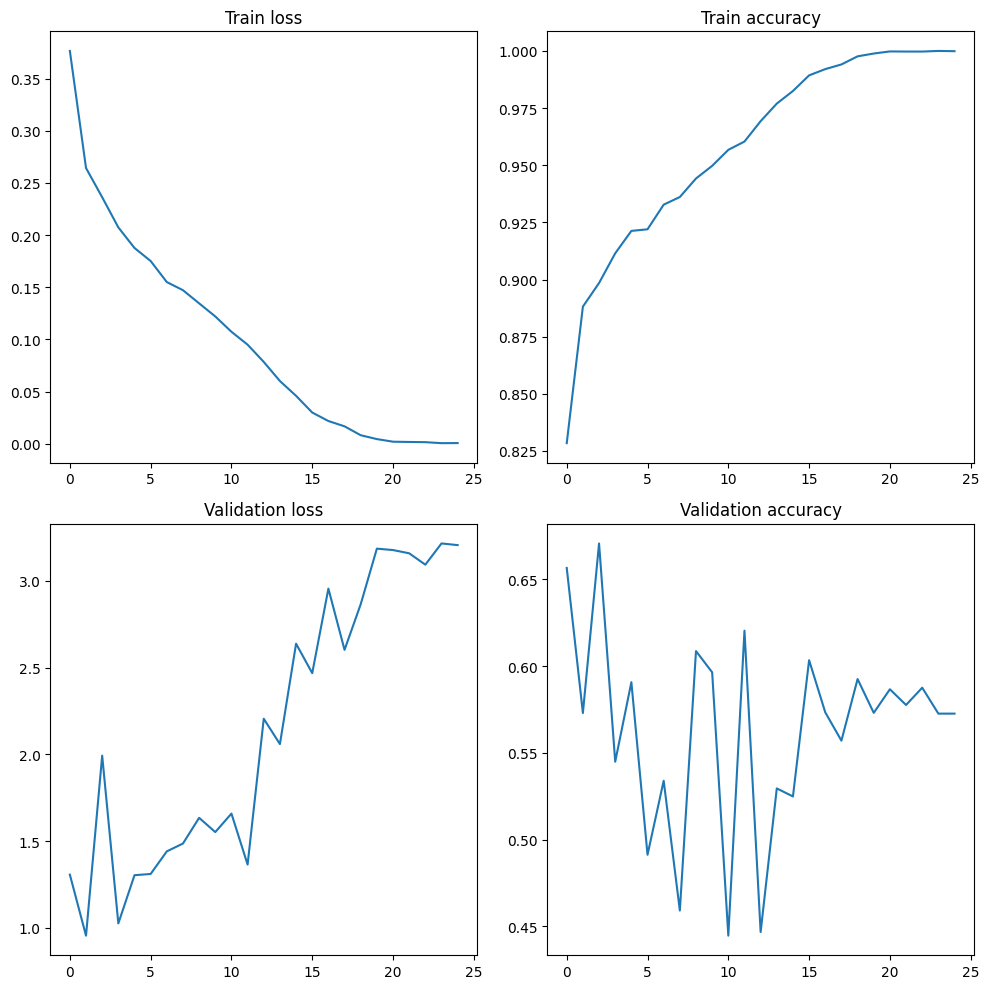

In [15]:
plot_experiment(train_loss, train_accuracy, val_loss, val_accuracy)

# ResNet 18

- ImageNet Weights

In [16]:
config = dict()
config['MODEL'] = 'resnet34'
config['MODEL_PRETRAINED'] = False
config['NUM_CLASSES'] = 2
config['NUM_WORKERS'] = 0
config['BATCH_SIZE'] = 32
config['LR'] = 1e-3
config['GRAD_CLIP'] = 0.1
config['DEVICE'] = 'cpu' if not torch.cuda.is_available() else 'cuda'
config['WEIGHT_DECAY'] = 1e-4
config['NUM_EPOCHS'] = 15

In [ ]:
train_loss, train_accuracy, val_loss, val_accuracy, best_accuracy = run_experiment(config)

Epoch #0 started.


  0%|▎                                                                                | 2/582 [00:55<4:36:15, 28.58s/it]

In [ ]:
plot_experiment(train_loss, train_accuracy, val_loss, val_accuracy)